# Disaster Tweets

Competition: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)

References:

1. [Disaster Tweet Classification using BERT & Neural Network](https://www.analyticsvidhya.com/blog/2021/12/disaster-tweet-classification-using-bert-neural-network/) - Analytics Vidhya.
2. [Handling imbalanced dataset in Machine Learning](https://www.youtube.com/watch?v=JnlM4yLFNuo) – YouTube.
3. [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/) - Machine Learning Mastery.
4. [Natural Language Processing: Cleaning up Tweets](https://medium.com/codex/natural-language-processing-cleaning-up-tweets-2b71793e91b5) - Medium.
5. [Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) - Machine Learning Mastery.
6. [How to split data into three sets (train, validation, and test) And why?How to split data into three sets (train, validation, and test) And why?](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c) - Towards Data Science.

## Imports

In [1]:
import numpy as np
import pandas as pd
import warnings

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Data Prep

- /kaggle/input/nlp-getting-started/sample_submission.csv
- /kaggle/input/nlp-getting-started/train.csv
- /kaggle/input/nlp-getting-started/test.csv

In [2]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

train_data.sample(n=10, random_state=23)

,id,keyword,location,text,target
1461,2109,catastrophe,NaN,.@robdelaney Catastrophe is anything but! I literally have been unable to stop ejaculating.,1
1837,2642,crashed,too far,He was only .4 of a second faster than me and I overtook him twice (then crashed) tru luv &lt;3 &lt;3,0
6144,8763,siren,NaN,Internet firms to be subject to new cybersecurity rules in EU... http://t.co/lafTJ2GyLY,0
2354,3389,demolition,"ÌÏT: 36.142163,-95.979189",@samajp32 really needs to tone it down some in the weight room. RT @SoonerSportsTV: Demolition (cont) http://t.co/2o7Eva1cOe,0
4765,6781,lightning,Elchilicitanierraversal,#NowPlaying 'The Lightning Strike' de Snow Patrol de A Hundred Million Suns ? http://t.co/GrzcHkDF37,0
6882,9866,traumatised,cork,@AnnmarieRonan @niamhosullivanx I can't watch tat show its like a horror movie to me I get flashbacks an everything #traumatised,0
3566,5097,famine,NaN,when things become terrible more than the great Ethiopian famine...,0
1847,2657,crush,NaN,'@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ??,1
4961,7071,meltdown,"Colorado, USA",@nprfreshair I really can't believe he is skipping out before the Republican meltdown...I mean 'debate'.,0
7021,10064,typhoon,"Ibadan,Oyo state",Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG,1


In [3]:
sample_sentence = train_data.iloc[[7021]].text.to_string(header=False, index=False)
sample_sentence

'Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG'

In [4]:
#df = train_data.drop(['id','keyword','location'],axis=1)
df = train_data.drop(['id'],axis=1)
df.sample(10, random_state=23)

# Is the dataset is balanced: count of both class labels (0 and 1):

df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Optional undersampling step

In [5]:
if False:
    df_0_class = df[df['target']==0]
    df_1_class = df[df['target']==1]
    df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
    df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)

    df['target'].value_counts()

### Process Tweets

In [6]:
!pip install contractions

import contractions, emoji, re, unidecode

from nltk.stem import PorterStemmer

class TweetSweeper:
    def __init__(self, tweets):
        self.tweets = tweets
        self.stemmer = PorterStemmer()
        self.tweets['text'] = self.tweets['text'].apply(lambda x: contractions.fix(x))
        self.tweets['text'] = self.tweets['text'].apply(lambda x: self.demojize(x))
        self.tweets['hashtags'] = self.tweets['text'].apply(lambda x: [x for x in x.split(" ") if x.startswith("#")])
        # Keyword
        self.tweets['keyword'] = self.tweets['keyword'].apply(str)
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.clean_keywords(x))
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.remove_accents(x))
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.remove_punctuation(x))
        self.tweets['stems'] = self.tweets['keyword'].apply(lambda x: self.stemmer.stem(x))
        # Location
        self.tweets['location'] = self.tweets['location'].apply(str)
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_accents(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_punctuation(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_extra_w_space(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_nums(x))
        
        # Counts
        self.tweets['emojis'] = self.tweets['text'].apply(self.emoji_count)
        self.tweets['num_hashtags'] = self.tweets['text'].apply(self.hash_count)
        
    def demojize(self, tweet):
        emojis = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags = re.UNICODE)
        cleaned_text = emojis.sub(r'', tweet)
        return cleaned_text
    
    def emoji_count(self, tweet):
        tweet = emoji.demojize(tweet, delimiters=('__','__'))
        pattern = r'_+[a-z_&]+_+'
        return len(re.findall(pattern, tweet))
    
    def hash_count(self, string):
        words = string.split()
        hashtags = [word for word in words if word.startswith('#')]
        return len(hashtags)
    
    def clean_keywords(self, keyword):
        cleaned = re.sub(r'%20', ' ', keyword)
        return cleaned
    
    def remove_accents(self, keyword):
        cleaned = unidecode.unidecode(keyword)
        return cleaned
    
    def remove_punctuation(self, keyword):
        cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]"," ",keyword)
        return cleaned
    
    def remove_nums(self, location):
        cleaned = re.sub(r'\d+', '', location)
        return cleaned

    def remove_extra_w_space(self, location):
        cleaned_text = re.sub(r"\s+"," ", location).strip()
        return cleaned_text

tweets = train_data.sample(n=10, random_state=23)
test = TweetSweeper(tweets)
test.tweets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.4 MB/s eta 0:00:00


,id,keyword,location,text,target,hashtags,stems,emojis,num_hashtags
1461,2109,catastrophe,nan,.@robdelaney Catastrophe is anything but! I literally have been unable to stop ejaculating.,1,[],catastroph,0,0
1837,2642,crashed,too far,He was only .4 of a second faster than me and I overtook him twice (then crashed) tru love &lt;3 &lt;3,0,[],crash,0,0
6144,8763,siren,nan,Internet firms to be subject to new cybersecurity rules in EU... http://t.co/lafTJ2GyLY,0,[],siren,0,0
2354,3389,demolition,IIT,@samajp32 really needs to tone it down some in the weight room. RT @SoonerSportsTV: Demolition (cont) http://t.co/2o7Eva1cOe,0,[],demolit,0,0
4765,6781,lightning,Elchilicitanierraversal,#NowPlaying 'The Lightning Strike' de Snow Patrol de A Hundred Million Suns ? http://t.co/GrzcHkDF37,0,[#NowPlaying],lightn,0,1
6882,9866,traumatised,cork,@AnnmarieRonan @niamhosullivanx I cannot watch tat show its like a horror movie to me I get flashbacks an everything #traumatised,0,[#traumatised],traumatis,0,1
3566,5097,famine,nan,when things become terrible more than the great Ethiopian famine...,0,[],famin,0,0
1847,2657,crush,nan,'@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ??,1,[],crush,0,0
4961,7071,meltdown,Colorado USA,@nprfreshair I really cannot believe he is skipping out before the Republican meltdown...I mean 'debate'.,0,[],meltdown,0,0
7021,10064,typhoon,Ibadan Oyo state,Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG,1,[],typhoon,0,0


Process the tweets now ..

In [7]:
#sweep = TweetSweeper(df)
#df['text'] = sweep.tweets['text'] 

## BERT Preprocessor & Encoder

In [8]:
def build_model():
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    d_layer = tf.keras.layers.Dropout(0.1, name='dropout-layer')(outputs['pooled_output'])
    d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(d_layer)

    model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])
    
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='f1_score')
    ]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text-layer[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Train / Validation / Test Splits

First split your whole data into train and test set. Then split the train set into train and validation sets as shown below.

In [9]:
# 60/20/20 split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, stratify=df['target'], random_state=1) # 0.8 train, 0.2 test

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2 val

## Model Training

In [10]:
# Use Accuracy: Update the example to monitor accuracy on the test dataset rather than loss,
# and plot learning curves showing accuracy.
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=7)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es])

Epoch 1/100
143/143 [==============================] - 54s 301ms/step - loss: 0.6380 - accuracy: 0.6319 - f1_score: 0.4735 - val_loss: 0.5906 - val_accuracy: 0.7091 - val_f1_score: 0.6992
Epoch 2/100
143/143 [==============================] - 42s 293ms/step - loss: 0.6024 - accuracy: 0.6845 - f1_score: 0.5698 - val_loss: 0.5760 - val_accuracy: 0.7177 - val_f1_score: 0.7145
Epoch 3/100
143/143 [==============================] - 42s 293ms/step - loss: 0.5882 - accuracy: 0.7077 - f1_score: 0.6004 - val_loss: 0.5672 - val_accuracy: 0.7196 - val_f1_score: 0.5679
Epoch 4/100
143/143 [==============================] - 42s 292ms/step - loss: 0.5742 - accuracy: 0.7099 - f1_score: 0.5994 - val_loss: 0.5643 - val_accuracy: 0.7196 - val_f1_score: 0.7405
Epoch 5/100
143/143 [==============================] - 52s 364ms/step - loss: 0.5678 - accuracy: 0.7145 - f1_score: 0.6177 - val_loss: 0.5530 - val_accuracy: 0.7354 - val_f1_score: 0.5802
Epoch 6/100
143/143 [==============================] - 42s 2

In [11]:
train_loss, train_acc, train_f1 = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc, val_f1 = model.evaluate(X_val, y_val, verbose=0)

print('[ACC] Train: %.3f, Val: %.3f' % (train_acc, val_acc))
print('[F1]  Train: %.3f, Val: %.3f' % (train_f1, val_f1))

[ACC] Train: 0.791, Val: 0.788
[F1]  Train: 0.746, Val: 0.748


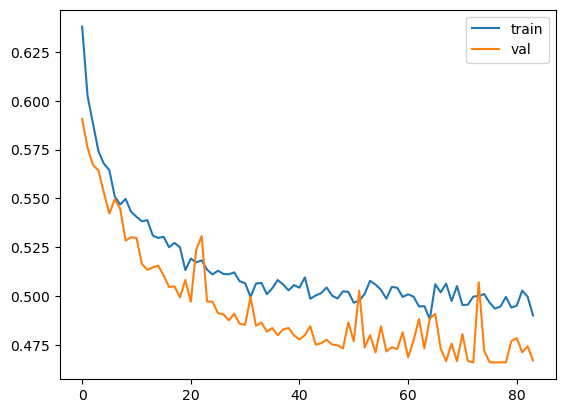

In [12]:
# plot log loss graph to determine how many epochs we need.

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Classification Report

A confusion matrix and classification report is a very statistically neat way to understand the performance of your model and take decisions accordingly, in case any improvement is required.

**Note:** Evaluate the final model on the "test" split.Evaluate the final model on the "test" split.

In [13]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

matrix = confusion_matrix(y_test, y_predicted)
matrix

48/48 [==============================] - 11s 220ms/step


array([[717, 152],
       [171, 483]])

In [14]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       869
           1       0.76      0.74      0.75       654

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



We used f1_score to validate our results, this is a competition requirement.

In [15]:
auc_roc = roc_auc_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'ROC-AUC: {auc_roc:.1%}')
print(f'f1: {f1:.1%}')

ROC-AUC: 78.2%
f1: 74.9%


## Submission

In [16]:
submission_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', index_col='id')

submission = model.predict(submission_data['text'])
submission = submission.flatten()

submission_predicted = np.where(submission > 0.5, 1, 0)
submission_data['target'] = submission_predicted.tolist()
submission_data.reset_index(inplace=True)

submission_data.head()

102/102 [==============================] - 22s 219ms/step


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [17]:
submission_data[['id', 'target']].to_csv('submission.csv', index= False)

!head -5 submission.csv

id,target
0,1
2,1
3,1
9,1
